<!--- Licensed to the Apache Software Foundation (ASF) under one -->
<!--- or more contributor license agreements.  See the NOTICE file -->
<!--- distributed with this work for additional information -->
<!--- regarding copyright ownership.  The ASF licenses this file -->
<!--- to you under the Apache License, Version 2.0 (the -->
<!--- "License"); you may not use this file except in compliance -->
<!--- with the License.  You may obtain a copy of the License at -->

<!---   http://www.apache.org/licenses/LICENSE-2.0 -->

<!--- Unless required by applicable law or agreed to in writing, -->
<!--- software distributed under the License is distributed on an -->
<!--- "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY -->
<!--- KIND, either express or implied.  See the License for the -->
<!--- specific language governing permissions and limitations -->
<!--- under the License. -->

# Step 6: Train a Neural Network

Now that you have seen all the necessary components for creating a neural network, you are
now ready to put all the pieces together and train a model end to end.

## 1. Data preparation

The typical process for creating and training a model starts with loading and
preparing the datasets. For this Network you will use a [dataset of leaf
images](https://data.mendeley.com/datasets/hb74ynkjcn/1) that consists of healthy
and diseased examples of leafs from twelve different plant species. To get this
dataset you have to download and extract it with the following commands.

In [1]:
# Import all the necessary libraries to train
import time
import os
import zipfile

import mxnet as mx
from mxnet import np, npx, gluon, init, autograd
from mxnet.gluon import nn
from mxnet.gluon.data.vision import transforms

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import numpy as np

from prepare_dataset import process_dataset #utility code to rearrange the data

mx.np.random.seed(42)

In [2]:
# Download dataset
url = 'https://md-datasets-cache-zipfiles-prod.s3.eu-west-1.amazonaws.com/hb74ynkjcn-1.zip'
zip_file_path = mx.gluon.utils.download(url)

os.makedirs('plants', exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zf:
    zf.extractall('plants')

os.remove(zip_file_path)

#### Data inspection

If you take a look at the dataset you find the following structure for the directories:

```
plants
|-- Alstonia Scholaris (P2)
|-- Arjun (P1)
|-- Bael (P4)
    |-- diseased
        |-- 0016_0001.JPG
        |-- .
        |-- .
        |-- .
        |-- 0016_0118.JPG
|-- .
|-- .
|-- .
|-- Mango (P0)
    |-- diseased
    |-- healthy
```


Each plant species has its own directory, for each of those directories you might
find subdirectories with examples of diseased leaves, healthy
leaves, or both. With this dataset you can formulate different classification
problems; for example, you can create a multi-class classifier that determines
the species of a plant based on the leaves; you can instead create a binary
classifier that tells you whether the plant is healthy or diseased. Additionally, you can create
a multi-class, multi-label classifier that tells you both: what species a
plant is and whether the plant is diseased or healthy. In this example you will stick to
the simplest classification question, which is whether a plant is healthy or not.

To do this, you need to manipulate the dataset in two ways. First, you need to
combine all images with labels consisting of healthy and diseased, regardless of the species, and then you
need to split the data into train, validation, and test sets. We prepared a
small utility script that does this to get the dataset ready for you.
Once you run this utility code on the data, the structure will be
already organized in folders containing the right images in each of the classes,
you can use the `ImageFolderDataset` class to import the images from the file to MXNet.

In [3]:
# Call the utility function to rearrange the images
process_dataset('plants')

The dataset is located in the `datasets` folder and the new structure
looks like this:

```
datasets
|-- test
    |-- diseased
    |-- healthy
|-- train
|-- validation
    |-- diseased
    |-- healthy
        |-- image1.JPG
        |-- image2.JPG
        |-- .
        |-- .
        |-- .
        |-- imagen.JPG
```


Now, you need to create three different Dataset objects from the `train`,
`validation`, and `test` folders, and the `ImageFolderDataset` class takes
care of inferring the classes from the directory names. If you don't remember
how the `ImageFolderDataset` works, take a look at [Step 5](5-datasets.md)
of this course for a deeper description.

In [4]:
# Use ImageFolderDataset to create a Dataset object from directory structure
train_dataset = gluon.data.vision.ImageFolderDataset('./datasets/train')
val_dataset = gluon.data.vision.ImageFolderDataset('./datasets/validation')
test_dataset = gluon.data.vision.ImageFolderDataset('./datasets/test')

The result from this operation is a different Dataset object for each folder.
These objects hold a collection of images and labels and as such they can be
indexed, to get the $i$-th element from the dataset. The $i$-th element is a
tuple with two objects, the first object of the tuple is the image in array
form and the second is the corresponding label for that image.

[15:13:58] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for CPU


Data type: uint8
Label: 0
Label description: diseased
Image shape: (4000, 6000, 3)


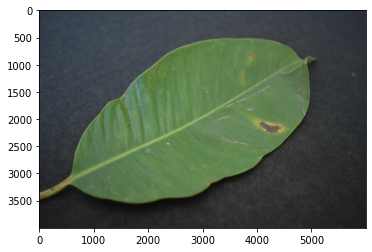

In [5]:
sample_idx = 888 # choose a random sample
sample = train_dataset[sample_idx]
data = sample[0]
label = sample[1]

plt.imshow(data.asnumpy())
print(f"Data type: {data.dtype}")
print(f"Label: {label}")
print(f"Label description: {train_dataset.synsets[label]}")
print(f"Image shape: {data.shape}")

As you can see from the plot, the image size is very large 4000 x 6000 pixels.
Usually, you downsize images before passing them to a neural network to reduce the training time.
It is also customary to make slight modifications to the images to improve generalization. That is why you add
transformations to the data in a process called Data Augmentation.

You can augment data in MXNet using `transforms`. For a complete list of all
the available transformations in MXNet check out
[available transforms](../../../api/gluon/data/vision/transforms/index.rst).
It is very common to use more than one transform per image, and it is also
common to process transforms sequentially. To this end, you can use the `transforms.Compose` class.
This class is very useful to create a transformation pipeline for your images.

You have to compose two different transformation pipelines, one for training
and the other one for validating and testing. This is because each pipeline
serves different pursposes. You need to downsize, convert to tensor and normalize
images across all the different datsets; however, you typically do not want to randomly flip
or add color jitter to the validation or test images since you could reduce performance.

In [6]:
# Import transforms as compose a series of transformations to the images
from mxnet.gluon.data.vision import transforms

jitter_param = 0.05

# mean and std for normalizing image value in range (0,1)
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

training_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.RandomFlipLeftRight(),
    transforms.RandomColorJitter(contrast=jitter_param),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

validation_transformer = transforms.Compose([
    transforms.Resize(size=224, keep_ratio=True),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)
])

With your augmentations ready, you can create the `DataLoaders` to use them. To
do this the `gluon.data.DataLoader` class comes in handy. You have to pass the dataset with
the applied transformations (notice the `.transform_first()` method on the datasets)
to `gluon.data.DataLoader`. Additionally, you need to decide the batch size,
which is how many images you will be passing to the network,
and whether you want to shuffle the dataset.

In [7]:
# Create data loaders
batch_size = 4
train_loader = gluon.data.DataLoader(train_dataset.transform_first(training_transformer),
                                     batch_size=batch_size,
                                     shuffle=True,
                                     try_nopython=True)
validation_loader = gluon.data.DataLoader(val_dataset.transform_first(validation_transformer),
                                          batch_size=batch_size,
                                          try_nopython=True)
test_loader = gluon.data.DataLoader(test_dataset.transform_first(validation_transformer),
                                    batch_size=batch_size,
                                    try_nopython=True)

Now, you can inspect the transformations that you made to the images. A prepared
utility function has been provided for this.

In [8]:
# Function to plot batch
def show_batch(batch, columns=4, fig_size=(9, 5), pad=1):
    labels = batch[1].asnumpy()
    batch = batch[0] / 2 + 0.5     # unnormalize
    batch = np.clip(batch.asnumpy(), 0, 1) # clip values
    size = batch.shape[0]
    rows = int(size / columns)
    fig, axes = plt.subplots(rows, columns, figsize=fig_size)
    for ax, img, label in zip(axes.flatten(), batch, labels):
        ax.imshow(np.transpose(img, (1, 2, 0)))
        ax.set(title=f"Label: {label}")
    fig.tight_layout(h_pad=pad, w_pad=pad)
    plt.show()

In [9]:
for batch in train_loader:
    a = batch
    break

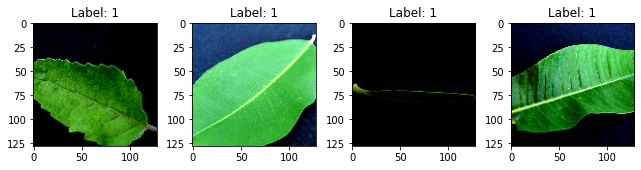

In [10]:
show_batch(a)

You can see that the original images changed to have different sizes and variations
in color and lighting. These changes followed the specified transformations you stated
in the pipeline. You are now ready to go to the next step: **Create the
architecture**.

## 2. Create Neural Network

Convolutional neural networks are a great tool to capture the spatial
relationship of pixel values within images, for this reason they have become the
gold standard for computer vision. In this example you will create a small convolutional neural
network using what you learned from [Step 2](2-create-nn.md) of this crash course series.
First, you can set up two functions that will generate the two types of blocks
you intend to use, the convolution block and the dense block. Then you can create an
entire network based on these two blocks using a custom class.

In [11]:
# The convolutional block has a convolution layer, a max pool layer and a batch normalization layer
def conv_block(filters, kernel_size=2, stride=2, batch_norm=True):
    conv_block = nn.HybridSequential()
    conv_block.add(nn.Conv2D(channels=filters, kernel_size=kernel_size, activation='relu'),
              nn.MaxPool2D(pool_size=4, strides=stride))
    if batch_norm:
        conv_block.add(nn.BatchNorm())
    return conv_block

# The dense block consists of a dense layer and a dropout layer
def dense_block(neurons, activation='relu', dropout=0.2):
    dense_block = nn.HybridSequential()
    dense_block.add(nn.Dense(neurons, activation=activation))
    if dropout:
        dense_block.add(nn.Dropout(dropout))
    return dense_block

In [12]:
# Create neural network blueprint using the blocks
class LeafNetwork(nn.HybridBlock):
    def __init__(self):
        super(LeafNetwork, self).__init__()
        self.conv1 = conv_block(32)
        self.conv2 = conv_block(64)
        self.conv3 = conv_block(128)
        self.flatten = nn.Flatten()
        self.dense1 = dense_block(100)
        self.dense2 = dense_block(10)
        self.dense3 = nn.Dense(2)

    def forward(self, batch):
        batch = self.conv1(batch)
        batch = self.conv2(batch)
        batch = self.conv3(batch)
        batch = self.flatten(batch)
        batch = self.dense1(batch)
        batch = self.dense2(batch)
        batch = self.dense3(batch)

        return batch

You have concluded the architecting part of the network, so now you can actually
build a model from that architecture for training. As you have seen
previously on [Step 4](4-components.md) of this
crash course series, to use the network you need to initialize the parameters and
hybridize the model.

In [13]:
# Create the model based on the blueprint provided and initialize the parameters
ctx = mx.gpu()

initializer = mx.initializer.Xavier()

model = LeafNetwork()
model.initialize(initializer, ctx=ctx)
model.summary(mx.np.random.uniform(size=(4, 3, 128, 128), ctx=ctx))
model.hybridize()

[15:14:04] /work/mxnet/src/storage/storage.cc:202: Using Pooled (Naive) StorageManager for GPU


--------------------------------------------------------------------------------
        Layer (type)                                Output Shape         Param #
               Input                            (4, 3, 128, 128)               0
        Activation-1                           (4, 32, 127, 127)               0
            Conv2D-2                           (4, 32, 127, 127)             416
         MaxPool2D-3                             (4, 32, 62, 62)               0
         BatchNorm-4                             (4, 32, 62, 62)             128
        Activation-5                             (4, 64, 61, 61)               0
            Conv2D-6                             (4, 64, 61, 61)            8256
         MaxPool2D-7                             (4, 64, 29, 29)               0
         BatchNorm-8                             (4, 64, 29, 29)             256
        Activation-9                            (4, 128, 28, 28)               0
           Conv2D-10        

[15:14:06] /work/mxnet/src/operator/nn/./cudnn/./cudnn_algoreg-inl.h:106: Running performance tests to find the best convolution algorithm, this can take a while... (set the environment variable MXNET_CUDNN_AUTOTUNE_DEFAULT to 0 to disable)


## 3. Choose Optimizer and Loss function

With the network created you can move on to choosing an optimizer and a loss
function. The network you created uses these components to make an informed decision on how
to tune the parameters to fit the final objective better. You can use the `gluon.Trainer` class to
help with optimizing these parameters. The `gluon.Trainer` class needs two things to work
properly: the parameters needing to be tuned and the optimizer with its
corresponding hyperparameters. The trainer uses the error reported by the loss
function to optimize these parameters.

For this particular dataset you will use Stochastic Gradient Descent as the
optimizer and Cross Entropy as the loss function.

In [14]:
# SGD optimizer
optimizer = 'sgd'

# Set parameters
optimizer_params = {'learning_rate': 0.001}

# Define the trainer for the model
trainer = gluon.Trainer(model.collect_params(), optimizer, optimizer_params)

# Define the loss function
loss_fn = gluon.loss.SoftmaxCrossEntropyLoss()

Finally, you have to set up the training loop, and you need to create a function to evaluate the performance of the network on the validation dataset.

In [15]:
# Function to return the accuracy for the validation and test set
def test(val_data):
    acc = gluon.metric.Accuracy()
    for batch in val_data:
        data = batch[0]
        labels = batch[1]
        outputs = model(data.as_in_ctx(ctx))
        acc.update([labels], [outputs])

    _, accuracy = acc.get()
    return accuracy

## 4. Training Loop

Now that you have everything set up, you can start training your network. This might
take some time to train depending on the hardware, number of layers, batch size and
images you use. For this particular case, you will only train for 2 epochs.

In [16]:
# Start the training loop
epochs = 2
accuracy = gluon.metric.Accuracy()
log_interval = 5

for epoch in range(epochs):
    tic = time.time()
    btic = time.time()
    accuracy.reset()

    for idx, batch in enumerate(train_loader):
        data = batch[0]
        label = batch[1]
        with mx.autograd.record():
            outputs = model(data.as_in_ctx(ctx))
            loss = loss_fn(outputs, label.as_in_ctx(ctx))
        mx.autograd.backward(loss)
        trainer.step(batch_size)
        accuracy.update([label], [outputs])
        if log_interval and (idx + 1) % log_interval == 0:
            _, acc = accuracy.get()

            print(f"""Epoch[{epoch + 1}] Batch[{idx + 1}] Speed: {batch_size / (time.time() - btic)} samples/sec \
                  batch loss = {loss.mean().item()} | accuracy = {acc}""")
            btic = time.time()

    _, acc = accuracy.get()

    acc_val = test(validation_loader)
    print(f"[Epoch {epoch + 1}] training: accuracy={acc}")
    print(f"[Epoch {epoch + 1}] time cost: {time.time() - tic}")
    print(f"[Epoch {epoch + 1}] validation: validation accuracy={acc_val}")

Epoch[1] Batch[5] Speed: 1.2530554643740461 samples/sec                   batch loss = 0.654442548751831 | accuracy = 0.65


Epoch[1] Batch[10] Speed: 1.2589911991067033 samples/sec                   batch loss = 0.5139572620391846 | accuracy = 0.7


Epoch[1] Batch[15] Speed: 1.2637016120819677 samples/sec                   batch loss = 0.7892762422561646 | accuracy = 0.6166666666666667


Epoch[1] Batch[20] Speed: 1.2704269214060584 samples/sec                   batch loss = 0.773726224899292 | accuracy = 0.6125


Epoch[1] Batch[25] Speed: 1.2734160720542167 samples/sec                   batch loss = 0.5798028707504272 | accuracy = 0.61


Epoch[1] Batch[30] Speed: 1.2305047417498862 samples/sec                   batch loss = 0.8777987957000732 | accuracy = 0.6166666666666667


Epoch[1] Batch[35] Speed: 1.27562690586942 samples/sec                   batch loss = 0.7515233755111694 | accuracy = 0.6285714285714286


Epoch[1] Batch[40] Speed: 1.2676206024191696 samples/sec                   batch loss = 0.7462297677993774 | accuracy = 0.6375


Epoch[1] Batch[45] Speed: 1.2724752590292285 samples/sec                   batch loss = 0.3693874776363373 | accuracy = 0.6388888888888888


Epoch[1] Batch[50] Speed: 1.2782080785032275 samples/sec                   batch loss = 0.5069169998168945 | accuracy = 0.625


Epoch[1] Batch[55] Speed: 1.2728349623089568 samples/sec                   batch loss = 0.6637282371520996 | accuracy = 0.6136363636363636


Epoch[1] Batch[60] Speed: 1.2757392303050359 samples/sec                   batch loss = 0.694629967212677 | accuracy = 0.6


Epoch[1] Batch[65] Speed: 1.2711253394365556 samples/sec                   batch loss = 1.105968952178955 | accuracy = 0.6115384615384616


Epoch[1] Batch[70] Speed: 1.2739613385009974 samples/sec                   batch loss = 0.3891187906265259 | accuracy = 0.6214285714285714


Epoch[1] Batch[75] Speed: 1.271411049546653 samples/sec                   batch loss = 0.3602590560913086 | accuracy = 0.63


Epoch[1] Batch[80] Speed: 1.2717755500072279 samples/sec                   batch loss = 1.1545332670211792 | accuracy = 0.625


Epoch[1] Batch[85] Speed: 1.2724733288033452 samples/sec                   batch loss = 0.5664479732513428 | accuracy = 0.6294117647058823


Epoch[1] Batch[90] Speed: 1.2692934354989045 samples/sec                   batch loss = 0.7730322480201721 | accuracy = 0.6222222222222222


Epoch[1] Batch[95] Speed: 1.2762501777195618 samples/sec                   batch loss = 0.256643682718277 | accuracy = 0.631578947368421


Epoch[1] Batch[100] Speed: 1.2734619844573905 samples/sec                   batch loss = 0.35581159591674805 | accuracy = 0.63


Epoch[1] Batch[105] Speed: 1.2701912727316225 samples/sec                   batch loss = 0.31189948320388794 | accuracy = 0.6285714285714286


Epoch[1] Batch[110] Speed: 1.2724701439434403 samples/sec                   batch loss = 0.8030833601951599 | accuracy = 0.6272727272727273


Epoch[1] Batch[115] Speed: 1.2749789532768065 samples/sec                   batch loss = 0.7493708729743958 | accuracy = 0.6304347826086957


Epoch[1] Batch[120] Speed: 1.2634190705671877 samples/sec                   batch loss = 0.6185778379440308 | accuracy = 0.6291666666666667


Epoch[1] Batch[125] Speed: 1.266314027494745 samples/sec                   batch loss = 0.7697910666465759 | accuracy = 0.632


Epoch[1] Batch[130] Speed: 1.2689031960413937 samples/sec                   batch loss = 0.4246632158756256 | accuracy = 0.6326923076923077


Epoch[1] Batch[135] Speed: 1.2664883877788502 samples/sec                   batch loss = 0.8786731958389282 | accuracy = 0.6351851851851852


Epoch[1] Batch[140] Speed: 1.2674966798239746 samples/sec                   batch loss = 0.3143722414970398 | accuracy = 0.6339285714285714


Epoch[1] Batch[145] Speed: 1.2691077418282148 samples/sec                   batch loss = 0.4734130799770355 | accuracy = 0.6362068965517241


Epoch[1] Batch[150] Speed: 1.2697532947354089 samples/sec                   batch loss = 0.8340696692466736 | accuracy = 0.6333333333333333


Epoch[1] Batch[155] Speed: 1.2711084859737405 samples/sec                   batch loss = 0.21649055182933807 | accuracy = 0.635483870967742


Epoch[1] Batch[160] Speed: 1.277024705470607 samples/sec                   batch loss = 0.3697105050086975 | accuracy = 0.6390625


Epoch[1] Batch[165] Speed: 1.3011048352673742 samples/sec                   batch loss = 0.19118838012218475 | accuracy = 0.6439393939393939


Epoch[1] Batch[170] Speed: 1.301734270706499 samples/sec                   batch loss = 1.4662795066833496 | accuracy = 0.6455882352941177


Epoch[1] Batch[175] Speed: 1.2975436470058503 samples/sec                   batch loss = 0.5106413960456848 | accuracy = 0.6457142857142857


Epoch[1] Batch[180] Speed: 1.3007882782474125 samples/sec                   batch loss = 0.4600330889225006 | accuracy = 0.6458333333333334


Epoch[1] Batch[185] Speed: 1.289747099970603 samples/sec                   batch loss = 0.4845413863658905 | accuracy = 0.6527027027027027


Epoch[1] Batch[190] Speed: 1.298216150012644 samples/sec                   batch loss = 1.3959206342697144 | accuracy = 0.65


Epoch[1] Batch[195] Speed: 1.3010061594795732 samples/sec                   batch loss = 0.3973109722137451 | accuracy = 0.6551282051282051


Epoch[1] Batch[200] Speed: 1.293607293578148 samples/sec                   batch loss = 0.525671660900116 | accuracy = 0.65625


Epoch[1] Batch[205] Speed: 1.2894857956248589 samples/sec                   batch loss = 0.8130834102630615 | accuracy = 0.6597560975609756


Epoch[1] Batch[210] Speed: 1.290312597409579 samples/sec                   batch loss = 0.6882137060165405 | accuracy = 0.6607142857142857


Epoch[1] Batch[215] Speed: 1.2935661007853665 samples/sec                   batch loss = 0.903504490852356 | accuracy = 0.6616279069767442


Epoch[1] Batch[220] Speed: 1.2997580638851103 samples/sec                   batch loss = 0.2836984694004059 | accuracy = 0.6659090909090909


Epoch[1] Batch[225] Speed: 1.2984948736543682 samples/sec                   batch loss = 0.7414029240608215 | accuracy = 0.6633333333333333


Epoch[1] Batch[230] Speed: 1.299403213172032 samples/sec                   batch loss = 1.1779686212539673 | accuracy = 0.6652173913043479


Epoch[1] Batch[235] Speed: 1.3002253529597125 samples/sec                   batch loss = 0.485533744096756 | accuracy = 0.6670212765957447


Epoch[1] Batch[240] Speed: 1.3006100935563611 samples/sec                   batch loss = 0.6919114589691162 | accuracy = 0.6677083333333333


Epoch[1] Batch[245] Speed: 1.2976819461714506 samples/sec                   batch loss = 0.9029499888420105 | accuracy = 0.6663265306122449


Epoch[1] Batch[250] Speed: 1.2996066372117743 samples/sec                   batch loss = 0.6054116487503052 | accuracy = 0.665


Epoch[1] Batch[255] Speed: 1.2919571485732362 samples/sec                   batch loss = 1.6270878314971924 | accuracy = 0.6617647058823529


Epoch[1] Batch[260] Speed: 1.2954459834085905 samples/sec                   batch loss = 0.704293966293335 | accuracy = 0.6615384615384615


Epoch[1] Batch[265] Speed: 1.2914718232295972 samples/sec                   batch loss = 0.45487383008003235 | accuracy = 0.6613207547169812


Epoch[1] Batch[270] Speed: 1.2954177763127914 samples/sec                   batch loss = 0.8357760906219482 | accuracy = 0.6638888888888889


Epoch[1] Batch[275] Speed: 1.294577328683296 samples/sec                   batch loss = 0.41330134868621826 | accuracy = 0.6654545454545454


Epoch[1] Batch[280] Speed: 1.2928369341117842 samples/sec                   batch loss = 0.3409654498100281 | accuracy = 0.6669642857142857


Epoch[1] Batch[285] Speed: 1.2950974819065393 samples/sec                   batch loss = 1.1213858127593994 | accuracy = 0.6657894736842105


Epoch[1] Batch[290] Speed: 1.2958786460841634 samples/sec                   batch loss = 0.4145275950431824 | accuracy = 0.6672413793103448


Epoch[1] Batch[295] Speed: 1.2986771034261428 samples/sec                   batch loss = 0.486768513917923 | accuracy = 0.6677966101694915


Epoch[1] Batch[300] Speed: 1.2931537190582059 samples/sec                   batch loss = 0.7066007852554321 | accuracy = 0.6666666666666666


Epoch[1] Batch[305] Speed: 1.2935535340149236 samples/sec                   batch loss = 0.6582581996917725 | accuracy = 0.6672131147540984


Epoch[1] Batch[310] Speed: 1.3034873762559511 samples/sec                   batch loss = 0.8546914458274841 | accuracy = 0.6669354838709678


Epoch[1] Batch[315] Speed: 1.300399098095661 samples/sec                   batch loss = 0.589326024055481 | accuracy = 0.6666666666666666


Epoch[1] Batch[320] Speed: 1.294338328292188 samples/sec                   batch loss = 1.779280424118042 | accuracy = 0.66484375


Epoch[1] Batch[325] Speed: 1.3011502432655078 samples/sec                   batch loss = 0.5175036191940308 | accuracy = 0.666923076923077


Epoch[1] Batch[330] Speed: 1.2954892966951201 samples/sec                   batch loss = 0.6736391186714172 | accuracy = 0.6666666666666666


Epoch[1] Batch[335] Speed: 1.2980867761036883 samples/sec                   batch loss = 0.45132508873939514 | accuracy = 0.6664179104477612


Epoch[1] Batch[340] Speed: 1.3028905439259189 samples/sec                   batch loss = 0.41048574447631836 | accuracy = 0.6669117647058823


Epoch[1] Batch[345] Speed: 1.2973183969010134 samples/sec                   batch loss = 0.3892664909362793 | accuracy = 0.6681159420289855


Epoch[1] Batch[350] Speed: 1.305229572198758 samples/sec                   batch loss = 0.5565459728240967 | accuracy = 0.6685714285714286


Epoch[1] Batch[355] Speed: 1.3021632614000298 samples/sec                   batch loss = 0.41358715295791626 | accuracy = 0.6697183098591549


Epoch[1] Batch[360] Speed: 1.2958568259231056 samples/sec                   batch loss = 0.4253461956977844 | accuracy = 0.66875


Epoch[1] Batch[365] Speed: 1.2973964479927964 samples/sec                   batch loss = 0.5753758549690247 | accuracy = 0.6698630136986301


Epoch[1] Batch[370] Speed: 1.2964586509817049 samples/sec                   batch loss = 0.8754914999008179 | accuracy = 0.6709459459459459


Epoch[1] Batch[375] Speed: 1.2958896565361178 samples/sec                   batch loss = 0.559782862663269 | accuracy = 0.6706666666666666


Epoch[1] Batch[380] Speed: 1.2901548311973678 samples/sec                   batch loss = 0.4720458984375 | accuracy = 0.6717105263157894


Epoch[1] Batch[385] Speed: 1.294941541980203 samples/sec                   batch loss = 1.0151268243789673 | accuracy = 0.672077922077922


Epoch[1] Batch[390] Speed: 1.2966715764933636 samples/sec                   batch loss = 0.5347986221313477 | accuracy = 0.6705128205128205


Epoch[1] Batch[395] Speed: 1.2925787581126051 samples/sec                   batch loss = 0.7174614071846008 | accuracy = 0.669620253164557


Epoch[1] Batch[400] Speed: 1.2919476971600234 samples/sec                   batch loss = 0.08746933192014694 | accuracy = 0.67125


Epoch[1] Batch[405] Speed: 1.2950525953478593 samples/sec                   batch loss = 0.44710832834243774 | accuracy = 0.6722222222222223


Epoch[1] Batch[410] Speed: 1.2996714725048693 samples/sec                   batch loss = 0.33726435899734497 | accuracy = 0.6737804878048781


Epoch[1] Batch[415] Speed: 1.305466110841104 samples/sec                   batch loss = 0.637321949005127 | accuracy = 0.672289156626506


Epoch[1] Batch[420] Speed: 1.296450435963228 samples/sec                   batch loss = 1.0070796012878418 | accuracy = 0.6714285714285714


Epoch[1] Batch[425] Speed: 1.3010947450315216 samples/sec                   batch loss = 0.39613258838653564 | accuracy = 0.6717647058823529


Epoch[1] Batch[430] Speed: 1.289279186405146 samples/sec                   batch loss = 0.4553225636482239 | accuracy = 0.6738372093023256


Epoch[1] Batch[435] Speed: 1.3000218359323361 samples/sec                   batch loss = 0.3641608655452728 | accuracy = 0.6758620689655173


Epoch[1] Batch[440] Speed: 1.2982401593432507 samples/sec                   batch loss = 0.3198518455028534 | accuracy = 0.6744318181818182


Epoch[1] Batch[445] Speed: 1.295452085105095 samples/sec                   batch loss = 0.968361496925354 | accuracy = 0.6752808988764045


Epoch[1] Batch[450] Speed: 1.2963089936817243 samples/sec                   batch loss = 1.0247751474380493 | accuracy = 0.6738888888888889


Epoch[1] Batch[455] Speed: 1.297499192795287 samples/sec                   batch loss = 0.7754198312759399 | accuracy = 0.6730769230769231


Epoch[1] Batch[460] Speed: 1.3029223153152558 samples/sec                   batch loss = 0.5990654826164246 | accuracy = 0.6717391304347826


Epoch[1] Batch[465] Speed: 1.2987934235156229 samples/sec                   batch loss = 0.36837977170944214 | accuracy = 0.6720430107526881


Epoch[1] Batch[470] Speed: 1.2965951156622608 samples/sec                   batch loss = 0.42625728249549866 | accuracy = 0.6707446808510639


Epoch[1] Batch[475] Speed: 1.3014757600254505 samples/sec                   batch loss = 0.6102593541145325 | accuracy = 0.6721052631578948


Epoch[1] Batch[480] Speed: 1.2919766487679982 samples/sec                   batch loss = 0.5091318488121033 | accuracy = 0.6739583333333333


Epoch[1] Batch[485] Speed: 1.2996554644320244 samples/sec                   batch loss = 0.2345845103263855 | accuracy = 0.6757731958762887


Epoch[1] Batch[490] Speed: 1.2955763321476097 samples/sec                   batch loss = 1.0998395681381226 | accuracy = 0.675


Epoch[1] Batch[495] Speed: 1.298941643686243 samples/sec                   batch loss = 0.2586081326007843 | accuracy = 0.6757575757575758


Epoch[1] Batch[500] Speed: 1.2979132466367018 samples/sec                   batch loss = 0.3799629211425781 | accuracy = 0.6765


Epoch[1] Batch[505] Speed: 1.2963519640286858 samples/sec                   batch loss = 0.5339351892471313 | accuracy = 0.6767326732673268


Epoch[1] Batch[510] Speed: 1.298074523079618 samples/sec                   batch loss = 0.8599021434783936 | accuracy = 0.6784313725490196


Epoch[1] Batch[515] Speed: 1.2942774187794868 samples/sec                   batch loss = 0.5908136367797852 | accuracy = 0.679126213592233


Epoch[1] Batch[520] Speed: 1.2998680314291755 samples/sec                   batch loss = 0.25897884368896484 | accuracy = 0.6788461538461539


Epoch[1] Batch[525] Speed: 1.2960469262290966 samples/sec                   batch loss = 0.3334929943084717 | accuracy = 0.6780952380952381


Epoch[1] Batch[530] Speed: 1.293935832653223 samples/sec                   batch loss = 0.6699965596199036 | accuracy = 0.6773584905660377


Epoch[1] Batch[535] Speed: 1.3012385456688362 samples/sec                   batch loss = 1.1789755821228027 | accuracy = 0.6771028037383178


Epoch[1] Batch[540] Speed: 1.2978757952645665 samples/sec                   batch loss = 0.7135133147239685 | accuracy = 0.6787037037037037


Epoch[1] Batch[545] Speed: 1.301872454457748 samples/sec                   batch loss = 0.6538642048835754 | accuracy = 0.6770642201834862


Epoch[1] Batch[550] Speed: 1.3036750621834974 samples/sec                   batch loss = 1.2874772548675537 | accuracy = 0.6768181818181818


Epoch[1] Batch[555] Speed: 1.3053015708075555 samples/sec                   batch loss = 0.5291666388511658 | accuracy = 0.6774774774774774


Epoch[1] Batch[560] Speed: 1.3094692522595215 samples/sec                   batch loss = 0.4181252717971802 | accuracy = 0.6772321428571428


Epoch[1] Batch[565] Speed: 1.311482196567208 samples/sec                   batch loss = 0.42535144090652466 | accuracy = 0.6769911504424779


Epoch[1] Batch[570] Speed: 1.3051284422932097 samples/sec                   batch loss = 0.49895381927490234 | accuracy = 0.6785087719298246


Epoch[1] Batch[575] Speed: 1.2923129207213166 samples/sec                   batch loss = 0.7209227681159973 | accuracy = 0.6795652173913044


Epoch[1] Batch[580] Speed: 1.3020991878380208 samples/sec                   batch loss = 0.9452931880950928 | accuracy = 0.6793103448275862


Epoch[1] Batch[585] Speed: 1.297716274623766 samples/sec                   batch loss = 0.4010305404663086 | accuracy = 0.6799145299145299


Epoch[1] Batch[590] Speed: 1.2989848893232978 samples/sec                   batch loss = 0.8168678879737854 | accuracy = 0.6796610169491526


Epoch[1] Batch[595] Speed: 1.3065398889428135 samples/sec                   batch loss = 1.4094198942184448 | accuracy = 0.6794117647058824


Epoch[1] Batch[600] Speed: 1.302073519757355 samples/sec                   batch loss = 0.2694863975048065 | accuracy = 0.68125


Epoch[1] Batch[605] Speed: 1.3004701615431808 samples/sec                   batch loss = 0.4152336120605469 | accuracy = 0.6822314049586777


Epoch[1] Batch[610] Speed: 1.3020747323998076 samples/sec                   batch loss = 0.5250992774963379 | accuracy = 0.6823770491803278


Epoch[1] Batch[615] Speed: 1.3001404121168085 samples/sec                   batch loss = 0.6760033965110779 | accuracy = 0.6821138211382114


Epoch[1] Batch[620] Speed: 1.301024823997112 samples/sec                   batch loss = 0.24900345504283905 | accuracy = 0.6838709677419355


Epoch[1] Batch[625] Speed: 1.2957452342954023 samples/sec                   batch loss = 0.4545154273509979 | accuracy = 0.6836


Epoch[1] Batch[630] Speed: 1.2984385968035155 samples/sec                   batch loss = 0.41938868165016174 | accuracy = 0.6849206349206349


Epoch[1] Batch[635] Speed: 1.2995307357873547 samples/sec                   batch loss = 0.3897276222705841 | accuracy = 0.6854330708661417


Epoch[1] Batch[640] Speed: 1.3009437129061927 samples/sec                   batch loss = 0.6134118437767029 | accuracy = 0.685546875


Epoch[1] Batch[645] Speed: 1.2971371499410007 samples/sec                   batch loss = 0.9428229331970215 | accuracy = 0.6852713178294574


Epoch[1] Batch[650] Speed: 1.3074564660866042 samples/sec                   batch loss = 0.4046586751937866 | accuracy = 0.6857692307692308


Epoch[1] Batch[655] Speed: 1.3017369977336086 samples/sec                   batch loss = 0.6669589281082153 | accuracy = 0.6854961832061068


Epoch[1] Batch[660] Speed: 1.295721717435902 samples/sec                   batch loss = 0.7985048890113831 | accuracy = 0.6848484848484848


Epoch[1] Batch[665] Speed: 1.293484321417117 samples/sec                   batch loss = 0.2996019124984741 | accuracy = 0.6857142857142857


Epoch[1] Batch[670] Speed: 1.2881820474098944 samples/sec                   batch loss = 0.3605228364467621 | accuracy = 0.6850746268656717


Epoch[1] Batch[675] Speed: 1.2934523106024949 samples/sec                   batch loss = 0.4261564612388611 | accuracy = 0.6859259259259259


Epoch[1] Batch[680] Speed: 1.297088712319138 samples/sec                   batch loss = 0.2735976576805115 | accuracy = 0.6867647058823529


Epoch[1] Batch[685] Speed: 1.2926200872285818 samples/sec                   batch loss = 0.5308853387832642 | accuracy = 0.6872262773722628


Epoch[1] Batch[690] Speed: 1.297554184003452 samples/sec                   batch loss = 0.4042470455169678 | accuracy = 0.6869565217391305


Epoch[1] Batch[695] Speed: 1.2966675678378645 samples/sec                   batch loss = 0.44443678855895996 | accuracy = 0.6866906474820144


Epoch[1] Batch[700] Speed: 1.2964468294026368 samples/sec                   batch loss = 0.5800583362579346 | accuracy = 0.6875


Epoch[1] Batch[705] Speed: 1.2926974743912123 samples/sec                   batch loss = 0.21520613133907318 | accuracy = 0.6879432624113475


Epoch[1] Batch[710] Speed: 1.2985230139091952 samples/sec                   batch loss = 0.5083816051483154 | accuracy = 0.6883802816901409


Epoch[1] Batch[715] Speed: 1.2947609585012732 samples/sec                   batch loss = 0.1275099217891693 | accuracy = 0.6891608391608391


Epoch[1] Batch[720] Speed: 1.2948820747854426 samples/sec                   batch loss = 0.28075358271598816 | accuracy = 0.6902777777777778


Epoch[1] Batch[725] Speed: 1.2937501421780482 samples/sec                   batch loss = 0.47770360112190247 | accuracy = 0.6896551724137931


Epoch[1] Batch[730] Speed: 1.3040668141226979 samples/sec                   batch loss = 0.4003073573112488 | accuracy = 0.690068493150685


Epoch[1] Batch[735] Speed: 1.2984611069584762 samples/sec                   batch loss = 0.2938421964645386 | accuracy = 0.6901360544217687


Epoch[1] Batch[740] Speed: 1.302142542918072 samples/sec                   batch loss = 0.8018628358840942 | accuracy = 0.6902027027027027


Epoch[1] Batch[745] Speed: 1.2976534408837017 samples/sec                   batch loss = 0.38836005330085754 | accuracy = 0.6902684563758389


Epoch[1] Batch[750] Speed: 1.3028789082951866 samples/sec                   batch loss = 0.34685367345809937 | accuracy = 0.691


Epoch[1] Batch[755] Speed: 1.2962567119265131 samples/sec                   batch loss = 0.21355889737606049 | accuracy = 0.6907284768211921


Epoch[1] Batch[760] Speed: 1.2991830515052813 samples/sec                   batch loss = 0.5943640470504761 | accuracy = 0.6914473684210526


Epoch[1] Batch[765] Speed: 1.3000299955374761 samples/sec                   batch loss = 0.611282229423523 | accuracy = 0.692156862745098


Epoch[1] Batch[770] Speed: 1.2972324311819208 samples/sec                   batch loss = 0.7228500247001648 | accuracy = 0.6928571428571428


Epoch[1] Batch[775] Speed: 1.3007560057528076 samples/sec                   batch loss = 0.6994242668151855 | accuracy = 0.6935483870967742


Epoch[1] Batch[780] Speed: 1.2949779246040323 samples/sec                   batch loss = 0.3052976131439209 | accuracy = 0.6932692307692307


Epoch[1] Batch[785] Speed: 1.3050975784555645 samples/sec                   batch loss = 0.45331916213035583 | accuracy = 0.6942675159235668


[Epoch 1] training: accuracy=0.6941624365482234
[Epoch 1] time cost: 635.7118072509766
[Epoch 1] validation: validation accuracy=0.7177777777777777


Epoch[2] Batch[5] Speed: 1.2992730994764796 samples/sec                   batch loss = 0.6197367310523987 | accuracy = 0.6


Epoch[2] Batch[10] Speed: 1.2965399051251345 samples/sec                   batch loss = 0.40543240308761597 | accuracy = 0.75


Epoch[2] Batch[15] Speed: 1.3059723822740643 samples/sec                   batch loss = 0.43718376755714417 | accuracy = 0.7833333333333333


Epoch[2] Batch[20] Speed: 1.299075513357417 samples/sec                   batch loss = 0.238682359457016 | accuracy = 0.8125


Epoch[2] Batch[25] Speed: 1.3006306624711912 samples/sec                   batch loss = 0.7375432848930359 | accuracy = 0.81


Epoch[2] Batch[30] Speed: 1.2976581582216071 samples/sec                   batch loss = 0.37346377968788147 | accuracy = 0.7916666666666666


Epoch[2] Batch[35] Speed: 1.2983613245761692 samples/sec                   batch loss = 0.3129587471485138 | accuracy = 0.7785714285714286


Epoch[2] Batch[40] Speed: 1.301011002113757 samples/sec                   batch loss = 0.3997970223426819 | accuracy = 0.775


Epoch[2] Batch[45] Speed: 1.287756880280449 samples/sec                   batch loss = 0.46533632278442383 | accuracy = 0.7722222222222223


Epoch[2] Batch[50] Speed: 1.2696112763216572 samples/sec                   batch loss = 0.30525779724121094 | accuracy = 0.765


Epoch[2] Batch[55] Speed: 1.2728018410287403 samples/sec                   batch loss = 0.6784669160842896 | accuracy = 0.7636363636363637


Epoch[2] Batch[60] Speed: 1.2704456808734848 samples/sec                   batch loss = 0.41389960050582886 | accuracy = 0.7541666666666667


Epoch[2] Batch[65] Speed: 1.2703996971131093 samples/sec                   batch loss = 0.6471249461174011 | accuracy = 0.7538461538461538


Epoch[2] Batch[70] Speed: 1.2692582897151987 samples/sec                   batch loss = 0.46955931186676025 | accuracy = 0.7678571428571429


Epoch[2] Batch[75] Speed: 1.2674572288742032 samples/sec                   batch loss = 0.17257575690746307 | accuracy = 0.7633333333333333


Epoch[2] Batch[80] Speed: 1.2614051678676566 samples/sec                   batch loss = 0.31182169914245605 | accuracy = 0.775


Epoch[2] Batch[85] Speed: 1.2659826459156946 samples/sec                   batch loss = 0.46760353446006775 | accuracy = 0.7647058823529411


Epoch[2] Batch[90] Speed: 1.2710247068203382 samples/sec                   batch loss = 0.3513992130756378 | accuracy = 0.7666666666666667


Epoch[2] Batch[95] Speed: 1.2734651742841832 samples/sec                   batch loss = 0.5648353099822998 | accuracy = 0.7710526315789473


Epoch[2] Batch[100] Speed: 1.2754112363370376 samples/sec                   batch loss = 0.24305671453475952 | accuracy = 0.7625


Epoch[2] Batch[105] Speed: 1.272731741613521 samples/sec                   batch loss = 0.43465059995651245 | accuracy = 0.7666666666666667


Epoch[2] Batch[110] Speed: 1.27310598423439 samples/sec                   batch loss = 0.5916551947593689 | accuracy = 0.7613636363636364


Epoch[2] Batch[115] Speed: 1.2730139242878702 samples/sec                   batch loss = 0.397015780210495 | accuracy = 0.7673913043478261


Epoch[2] Batch[120] Speed: 1.274598186138777 samples/sec                   batch loss = 0.5019192695617676 | accuracy = 0.7625


Epoch[2] Batch[125] Speed: 1.2788175971633893 samples/sec                   batch loss = 0.33186447620391846 | accuracy = 0.768


Epoch[2] Batch[130] Speed: 1.2696696941230496 samples/sec                   batch loss = 0.4327569901943207 | accuracy = 0.7653846153846153


Epoch[2] Batch[135] Speed: 1.2791692894750968 samples/sec                   batch loss = 0.18625973165035248 | accuracy = 0.762962962962963


Epoch[2] Batch[140] Speed: 1.2823502057374745 samples/sec                   batch loss = 0.46914002299308777 | accuracy = 0.7642857142857142


Epoch[2] Batch[145] Speed: 1.277127651516795 samples/sec                   batch loss = 0.7812283635139465 | accuracy = 0.756896551724138


Epoch[2] Batch[150] Speed: 1.2720543189088664 samples/sec                   batch loss = 1.1424885988235474 | accuracy = 0.7516666666666667


Epoch[2] Batch[155] Speed: 1.273404956917539 samples/sec                   batch loss = 0.6773270964622498 | accuracy = 0.7516129032258064


Epoch[2] Batch[160] Speed: 1.27252911469233 samples/sec                   batch loss = 1.6084041595458984 | accuracy = 0.7515625


Epoch[2] Batch[165] Speed: 1.2722921066806647 samples/sec                   batch loss = 0.5666611790657043 | accuracy = 0.7515151515151515


Epoch[2] Batch[170] Speed: 1.2745629396328968 samples/sec                   batch loss = 0.5620478391647339 | accuracy = 0.7485294117647059


Epoch[2] Batch[175] Speed: 1.276368535200904 samples/sec                   batch loss = 0.5359599590301514 | accuracy = 0.7442857142857143


Epoch[2] Batch[180] Speed: 1.2754821160733842 samples/sec                   batch loss = 0.19943802058696747 | accuracy = 0.7430555555555556


Epoch[2] Batch[185] Speed: 1.2747811313242448 samples/sec                   batch loss = 0.6676410436630249 | accuracy = 0.7378378378378379


Epoch[2] Batch[190] Speed: 1.2698697773900087 samples/sec                   batch loss = 0.1455278843641281 | accuracy = 0.743421052631579


Epoch[2] Batch[195] Speed: 1.2687775832869879 samples/sec                   batch loss = 0.20810987055301666 | accuracy = 0.7448717948717949


Epoch[2] Batch[200] Speed: 1.2712582566884167 samples/sec                   batch loss = 0.42887383699417114 | accuracy = 0.745


Epoch[2] Batch[205] Speed: 1.268950127279119 samples/sec                   batch loss = 0.5159578323364258 | accuracy = 0.7414634146341463


Epoch[2] Batch[210] Speed: 1.272798171721834 samples/sec                   batch loss = 0.2953754961490631 | accuracy = 0.7404761904761905


Epoch[2] Batch[215] Speed: 1.2683015553937955 samples/sec                   batch loss = 0.7527269124984741 | accuracy = 0.7406976744186047


Epoch[2] Batch[220] Speed: 1.2694713068523176 samples/sec                   batch loss = 0.4131263196468353 | accuracy = 0.7431818181818182


Epoch[2] Batch[225] Speed: 1.2672654671320422 samples/sec                   batch loss = 0.4661810100078583 | accuracy = 0.7455555555555555


Epoch[2] Batch[230] Speed: 1.2716375125583672 samples/sec                   batch loss = 0.9300228953361511 | accuracy = 0.7434782608695653


Epoch[2] Batch[235] Speed: 1.2626269346308288 samples/sec                   batch loss = 0.7852737903594971 | accuracy = 0.7414893617021276


Epoch[2] Batch[240] Speed: 1.2752124078842486 samples/sec                   batch loss = 0.37647759914398193 | accuracy = 0.7416666666666667


Epoch[2] Batch[245] Speed: 1.2772141818051432 samples/sec                   batch loss = 0.5128052830696106 | accuracy = 0.7418367346938776


Epoch[2] Batch[250] Speed: 1.272718707449682 samples/sec                   batch loss = 0.5272091031074524 | accuracy = 0.742


Epoch[2] Batch[255] Speed: 1.2723430520930445 samples/sec                   batch loss = 0.419761598110199 | accuracy = 0.7411764705882353


Epoch[2] Batch[260] Speed: 1.2705198583476063 samples/sec                   batch loss = 0.30506986379623413 | accuracy = 0.7442307692307693


Epoch[2] Batch[265] Speed: 1.2738235031950336 samples/sec                   batch loss = 0.4372977018356323 | accuracy = 0.7433962264150943


Epoch[2] Batch[270] Speed: 1.2759813091717591 samples/sec                   batch loss = 0.717767596244812 | accuracy = 0.7435185185185185


Epoch[2] Batch[275] Speed: 1.2708251258215812 samples/sec                   batch loss = 0.6125608086585999 | accuracy = 0.7436363636363637


Epoch[2] Batch[280] Speed: 1.2708314790986628 samples/sec                   batch loss = 0.4965263903141022 | accuracy = 0.7446428571428572


Epoch[2] Batch[285] Speed: 1.2727901572566351 samples/sec                   batch loss = 0.7920522689819336 | accuracy = 0.7429824561403509


Epoch[2] Batch[290] Speed: 1.2665216593401807 samples/sec                   batch loss = 0.49668821692466736 | accuracy = 0.743103448275862


Epoch[2] Batch[295] Speed: 1.2681155766986896 samples/sec                   batch loss = 0.41545194387435913 | accuracy = 0.7432203389830508


Epoch[2] Batch[300] Speed: 1.2740615659144279 samples/sec                   batch loss = 0.13070598244667053 | accuracy = 0.745


Epoch[2] Batch[305] Speed: 1.2732935263151024 samples/sec                   batch loss = 0.7985395193099976 | accuracy = 0.7459016393442623


Epoch[2] Batch[310] Speed: 1.2698839066899774 samples/sec                   batch loss = 0.3596841096878052 | accuracy = 0.7443548387096774


Epoch[2] Batch[315] Speed: 1.270540448702429 samples/sec                   batch loss = 0.4123995900154114 | accuracy = 0.7428571428571429


Epoch[2] Batch[320] Speed: 1.274123490344103 samples/sec                   batch loss = 0.3633810579776764 | accuracy = 0.7421875


Epoch[2] Batch[325] Speed: 1.277029468424774 samples/sec                   batch loss = 0.6790236830711365 | accuracy = 0.7430769230769231


Epoch[2] Batch[330] Speed: 1.2728569797405385 samples/sec                   batch loss = 0.18616558611392975 | accuracy = 0.7446969696969697


Epoch[2] Batch[335] Speed: 1.2699130313410985 samples/sec                   batch loss = 0.49621468782424927 | accuracy = 0.7440298507462687


Epoch[2] Batch[340] Speed: 1.2741142980561293 samples/sec                   batch loss = 0.5974740386009216 | accuracy = 0.7448529411764706


Epoch[2] Batch[345] Speed: 1.2726965017113325 samples/sec                   batch loss = 0.4681498408317566 | accuracy = 0.7442028985507246


Epoch[2] Batch[350] Speed: 1.2705260161407812 samples/sec                   batch loss = 0.43495577573776245 | accuracy = 0.7435714285714285


Epoch[2] Batch[355] Speed: 1.2681791292618985 samples/sec                   batch loss = 0.9580911993980408 | accuracy = 0.7429577464788732


Epoch[2] Batch[360] Speed: 1.2684330196301035 samples/sec                   batch loss = 0.3941957354545593 | accuracy = 0.7423611111111111


Epoch[2] Batch[365] Speed: 1.271560795201464 samples/sec                   batch loss = 0.39786770939826965 | accuracy = 0.7431506849315068


Epoch[2] Batch[370] Speed: 1.2690494717177772 samples/sec                   batch loss = 0.4041840434074402 | accuracy = 0.7432432432432432


Epoch[2] Batch[375] Speed: 1.2703545823909783 samples/sec                   batch loss = 0.36061379313468933 | accuracy = 0.7426666666666667


Epoch[2] Batch[380] Speed: 1.2652956871295964 samples/sec                   batch loss = 0.32593417167663574 | accuracy = 0.7427631578947368


Epoch[2] Batch[385] Speed: 1.2721502915095204 samples/sec                   batch loss = 0.18270720541477203 | accuracy = 0.7448051948051948


Epoch[2] Batch[390] Speed: 1.2655454647974018 samples/sec                   batch loss = 0.43948978185653687 | accuracy = 0.7455128205128205


Epoch[2] Batch[395] Speed: 1.2743652467441515 samples/sec                   batch loss = 0.3174879550933838 | accuracy = 0.7449367088607595


Epoch[2] Batch[400] Speed: 1.2656899169786906 samples/sec                   batch loss = 0.5990392565727234 | accuracy = 0.743125


Epoch[2] Batch[405] Speed: 1.2760689459305736 samples/sec                   batch loss = 0.15539351105690002 | accuracy = 0.7438271604938271


Epoch[2] Batch[410] Speed: 1.2784395998597293 samples/sec                   batch loss = 0.5703518986701965 | accuracy = 0.7457317073170732


Epoch[2] Batch[415] Speed: 1.2716615127278967 samples/sec                   batch loss = 0.8514050841331482 | accuracy = 0.7469879518072289


Epoch[2] Batch[420] Speed: 1.2743689250919685 samples/sec                   batch loss = 0.1962801218032837 | accuracy = 0.7458333333333333


Epoch[2] Batch[425] Speed: 1.2693502874443299 samples/sec                   batch loss = 1.2353564500808716 | accuracy = 0.7452941176470588


Epoch[2] Batch[430] Speed: 1.2716266212140093 samples/sec                   batch loss = 0.5855401158332825 | accuracy = 0.7447674418604651


Epoch[2] Batch[435] Speed: 1.2735937472719088 samples/sec                   batch loss = 0.17297455668449402 | accuracy = 0.7471264367816092


Epoch[2] Batch[440] Speed: 1.278127158340219 samples/sec                   batch loss = 0.31599459052085876 | accuracy = 0.7488636363636364


Epoch[2] Batch[445] Speed: 1.272699011886387 samples/sec                   batch loss = 0.2736818790435791 | accuracy = 0.7477528089887641


Epoch[2] Batch[450] Speed: 1.2716428137226814 samples/sec                   batch loss = 0.39611825346946716 | accuracy = 0.7477777777777778


Epoch[2] Batch[455] Speed: 1.2783632284774544 samples/sec                   batch loss = 0.37909698486328125 | accuracy = 0.7467032967032967


Epoch[2] Batch[460] Speed: 1.2802989956074184 samples/sec                   batch loss = 0.5134059190750122 | accuracy = 0.7472826086956522


Epoch[2] Batch[465] Speed: 1.2741130401744079 samples/sec                   batch loss = 0.626047670841217 | accuracy = 0.7478494623655914


Epoch[2] Batch[470] Speed: 1.2732526507667838 samples/sec                   batch loss = 0.6706417798995972 | accuracy = 0.7484042553191489


Epoch[2] Batch[475] Speed: 1.2757974372747973 samples/sec                   batch loss = 0.5557106733322144 | accuracy = 0.7489473684210526


Epoch[2] Batch[480] Speed: 1.2746815654410675 samples/sec                   batch loss = 0.14925679564476013 | accuracy = 0.7489583333333333


Epoch[2] Batch[485] Speed: 1.2749812786794898 samples/sec                   batch loss = 0.1913752406835556 | accuracy = 0.7505154639175258


Epoch[2] Batch[490] Speed: 1.277977127726064 samples/sec                   batch loss = 0.30079931020736694 | accuracy = 0.7515306122448979


Epoch[2] Batch[495] Speed: 1.2749766278826056 samples/sec                   batch loss = 0.15778440237045288 | accuracy = 0.7515151515151515


Epoch[2] Batch[500] Speed: 1.2768376175248939 samples/sec                   batch loss = 0.29739582538604736 | accuracy = 0.7525


Epoch[2] Batch[505] Speed: 1.2672512045982718 samples/sec                   batch loss = 0.4181217551231384 | accuracy = 0.753960396039604


Epoch[2] Batch[510] Speed: 1.2679719119533817 samples/sec                   batch loss = 0.31587645411491394 | accuracy = 0.7544117647058823


Epoch[2] Batch[515] Speed: 1.2687502377410864 samples/sec                   batch loss = 0.5966407060623169 | accuracy = 0.7524271844660194


Epoch[2] Batch[520] Speed: 1.269333384982641 samples/sec                   batch loss = 0.6779863238334656 | accuracy = 0.7514423076923077


Epoch[2] Batch[525] Speed: 1.265006232584428 samples/sec                   batch loss = 0.5179937481880188 | accuracy = 0.7523809523809524


Epoch[2] Batch[530] Speed: 1.2700982877021365 samples/sec                   batch loss = 0.46054545044898987 | accuracy = 0.7518867924528302


Epoch[2] Batch[535] Speed: 1.2724630987039276 samples/sec                   batch loss = 0.613044023513794 | accuracy = 0.7514018691588785


Epoch[2] Batch[540] Speed: 1.2805432969111727 samples/sec                   batch loss = 0.5542802810668945 | accuracy = 0.750462962962963


Epoch[2] Batch[545] Speed: 1.2722127055840295 samples/sec                   batch loss = 0.24904081225395203 | accuracy = 0.7504587155963303


Epoch[2] Batch[550] Speed: 1.274234969488097 samples/sec                   batch loss = 0.09961556643247604 | accuracy = 0.7513636363636363


Epoch[2] Batch[555] Speed: 1.2732406688339635 samples/sec                   batch loss = 0.5354533791542053 | accuracy = 0.7522522522522522


Epoch[2] Batch[560] Speed: 1.2663730025463 samples/sec                   batch loss = 0.2811812162399292 | accuracy = 0.7535714285714286


Epoch[2] Batch[565] Speed: 1.2705735486154168 samples/sec                   batch loss = 0.3994125723838806 | accuracy = 0.7530973451327434


Epoch[2] Batch[570] Speed: 1.2764345686015595 samples/sec                   batch loss = 0.4368223547935486 | accuracy = 0.7543859649122807


Epoch[2] Batch[575] Speed: 1.2667150131770037 samples/sec                   batch loss = 0.07567537575960159 | accuracy = 0.7552173913043478


Epoch[2] Batch[580] Speed: 1.272936171536506 samples/sec                   batch loss = 0.9857778549194336 | accuracy = 0.7547413793103448


Epoch[2] Batch[585] Speed: 1.2744566309367116 samples/sec                   batch loss = 0.3282419741153717 | accuracy = 0.7534188034188034


Epoch[2] Batch[590] Speed: 1.275777064231206 samples/sec                   batch loss = 0.7667426466941833 | accuracy = 0.7533898305084745


Epoch[2] Batch[595] Speed: 1.2701456920191105 samples/sec                   batch loss = 0.3691820204257965 | accuracy = 0.753781512605042


Epoch[2] Batch[600] Speed: 1.2703551595313687 samples/sec                   batch loss = 0.5942538976669312 | accuracy = 0.7541666666666667


Epoch[2] Batch[605] Speed: 1.2722960625230253 samples/sec                   batch loss = 0.3131416141986847 | accuracy = 0.7557851239669422


Epoch[2] Batch[610] Speed: 1.2686583269669338 samples/sec                   batch loss = 0.5434702038764954 | accuracy = 0.7545081967213115


Epoch[2] Batch[615] Speed: 1.270229451499922 samples/sec                   batch loss = 0.21793074905872345 | accuracy = 0.7544715447154472


Epoch[2] Batch[620] Speed: 1.269838636369657 samples/sec                   batch loss = 0.5539944767951965 | accuracy = 0.7548387096774194


Epoch[2] Batch[625] Speed: 1.2750681966882702 samples/sec                   batch loss = 0.34129902720451355 | accuracy = 0.7548


Epoch[2] Batch[630] Speed: 1.2763449396279194 samples/sec                   batch loss = 1.2369494438171387 | accuracy = 0.7551587301587301


Epoch[2] Batch[635] Speed: 1.2770325789446322 samples/sec                   batch loss = 0.3220931887626648 | accuracy = 0.7562992125984253


Epoch[2] Batch[640] Speed: 1.2725977438362066 samples/sec                   batch loss = 0.8821004629135132 | accuracy = 0.7546875


Epoch[2] Batch[645] Speed: 1.2744048384982134 samples/sec                   batch loss = 0.49572426080703735 | accuracy = 0.7546511627906977


Epoch[2] Batch[650] Speed: 1.293025950050088 samples/sec                   batch loss = 0.19656403362751007 | accuracy = 0.7553846153846154


Epoch[2] Batch[655] Speed: 1.2924217315716915 samples/sec                   batch loss = 0.7106326222419739 | accuracy = 0.7549618320610687


Epoch[2] Batch[660] Speed: 1.3014496117344143 samples/sec                   batch loss = 0.67683345079422 | accuracy = 0.7549242424242424


Epoch[2] Batch[665] Speed: 1.3006615170633167 samples/sec                   batch loss = 0.4848323166370392 | accuracy = 0.7552631578947369


Epoch[2] Batch[670] Speed: 1.3008622084660484 samples/sec                   batch loss = 1.5699857473373413 | accuracy = 0.7548507462686567


Epoch[2] Batch[675] Speed: 1.2989431522065065 samples/sec                   batch loss = 0.7833995223045349 | accuracy = 0.7533333333333333


Epoch[2] Batch[680] Speed: 1.289103249179136 samples/sec                   batch loss = 0.27434995770454407 | accuracy = 0.7525735294117647


Epoch[2] Batch[685] Speed: 1.292970544819345 samples/sec                   batch loss = 0.5117547512054443 | accuracy = 0.7521897810218978


Epoch[2] Batch[690] Speed: 1.292473007445125 samples/sec                   batch loss = 0.552452027797699 | accuracy = 0.7503623188405797


Epoch[2] Batch[695] Speed: 1.296638606038315 samples/sec                   batch loss = 0.5565981864929199 | accuracy = 0.7510791366906475


Epoch[2] Batch[700] Speed: 1.298640412128992 samples/sec                   batch loss = 0.5089439153671265 | accuracy = 0.7510714285714286


Epoch[2] Batch[705] Speed: 1.291568958555543 samples/sec                   batch loss = 0.25826495885849 | accuracy = 0.7510638297872341


Epoch[2] Batch[710] Speed: 1.2850212810479302 samples/sec                   batch loss = 0.6403923034667969 | accuracy = 0.7514084507042254


Epoch[2] Batch[715] Speed: 1.2899897637166235 samples/sec                   batch loss = 0.2914469540119171 | accuracy = 0.7506993006993007


Epoch[2] Batch[720] Speed: 1.2907905965611572 samples/sec                   batch loss = 0.5689623951911926 | accuracy = 0.7496527777777777


Epoch[2] Batch[725] Speed: 1.2915043326075435 samples/sec                   batch loss = 0.34297579526901245 | accuracy = 0.75


Epoch[2] Batch[730] Speed: 1.2895260351470297 samples/sec                   batch loss = 0.8353725671768188 | accuracy = 0.7496575342465753


Epoch[2] Batch[735] Speed: 1.2969856314519412 samples/sec                   batch loss = 0.5959866046905518 | accuracy = 0.7496598639455783


Epoch[2] Batch[740] Speed: 1.290726743579973 samples/sec                   batch loss = 0.8555959463119507 | accuracy = 0.7493243243243243


Epoch[2] Batch[745] Speed: 1.2976565523154908 samples/sec                   batch loss = 0.1893036961555481 | accuracy = 0.7506711409395973


Epoch[2] Batch[750] Speed: 1.2922562826169774 samples/sec                   batch loss = 0.5413536429405212 | accuracy = 0.7506666666666667


Epoch[2] Batch[755] Speed: 1.294605299394745 samples/sec                   batch loss = 0.40183040499687195 | accuracy = 0.7503311258278146


Epoch[2] Batch[760] Speed: 1.2911714623150097 samples/sec                   batch loss = 0.5741032958030701 | accuracy = 0.7506578947368421


Epoch[2] Batch[765] Speed: 1.2930008377384608 samples/sec                   batch loss = 1.1815544366836548 | accuracy = 0.7496732026143791


Epoch[2] Batch[770] Speed: 1.2939295456450772 samples/sec                   batch loss = 0.48164454102516174 | accuracy = 0.7493506493506493


Epoch[2] Batch[775] Speed: 1.2919521741279916 samples/sec                   batch loss = 1.0344973802566528 | accuracy = 0.7496774193548387


Epoch[2] Batch[780] Speed: 1.2916299117219237 samples/sec                   batch loss = 0.19018611311912537 | accuracy = 0.7496794871794872


Epoch[2] Batch[785] Speed: 1.2947693519684493 samples/sec                   batch loss = 0.38984283804893494 | accuracy = 0.7490445859872611


[Epoch 2] training: accuracy=0.7496827411167513
[Epoch 2] time cost: 632.6387107372284
[Epoch 2] validation: validation accuracy=0.7811111111111111


## 5. Test on the test set

Now that your network is trained and has reached a decent accuracy, you can
evaluate the performance on the test set. For that, you can use the `test_loader` data
loader and the test function you created previously.

In [17]:
test(test_loader)

0.7911111111111111

You have a trained network that can confidently discriminate between plants that
are healthy and the ones that are diseased. You can now start your garden and
set cameras to automatically detect plants in distress! Or change your classification
problem to create a model that classify the species of the plants! Either way you
might be able to impress your botanist friends.

## 6. Save the parameters

If you want to preserve the trained weights of the network you can save the
parameters in a file. Later, when you want to use the network to make predictions
you can load the parameters back!

In [18]:
# Save parameters in the
model.save_parameters('leaf_models.params')

This is the end of this tutorial, to see how you can speed up the training by
using GPU hardware continue to the [next tutorial](./7-use-gpus.ipynb)